In [1]:
from zipfile import ZipFile
file_name="cell_images.zip"

with ZipFile(file_name,'r') as zip:
  zip.extractall()
  print('Done') 

Done


In [2]:
from keras.layers import Input, Lambda, Dense, Flatten
from keras.models import Model
#from keras.applications.vgg16 import VGG16
from keras.applications.vgg19 import VGG19
from keras.applications.vgg16 import preprocess_input
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
import numpy as np
from glob import glob
import matplotlib.pyplot as plt


Using TensorFlow backend.


In [0]:
# re-size all the images to this
IMAGE_SIZE = [224, 224]

In [0]:
train_path = 'cell_images/Train'
valid_path = 'cell_images/Test'

In [5]:
# add preprocessing layer to the front of VGG
vgg = VGG19(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)

# don't train existing weights
for layer in vgg.layers:
  layer.trainable = False
  

80142336/80134624 [==============================] - 2s 0us/step


In [0]:
# useful for getting number of classes
folders = glob('cell_images/Train/*')

# our layers - you can add more if you want
x = Flatten()(vgg.output)
# x = Dense(1000, activation='relu')(x)
prediction = Dense(len(folders), activation='softmax')(x)

# create a model object
model = Model(inputs=vgg.input, outputs=prediction)


In [8]:
# view the structure of the model
model.summary()


Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0   

In [0]:
# tell the model what cost and optimization method to use
model.compile(
  loss='categorical_crossentropy',
  optimizer='adam',
  metrics=['accuracy']
)


In [10]:
# Use the Image Data Generator to import the images from the dataset
from keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale = 1./255,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)

test_datagen = ImageDataGenerator(rescale = 1./255)

training_set = train_datagen.flow_from_directory('cell_images/Train',
                                                 target_size = (224, 224),
                                                 batch_size = 32,
                                                 class_mode = 'categorical')

test_set = test_datagen.flow_from_directory('cell_images/Test',
                                            target_size = (224, 224),
                                            batch_size = 32,
                                            class_mode = 'categorical')


Found 473 images belonging to 2 classes.
Found 110 images belonging to 2 classes.


In [12]:
# fit the model
r = model.fit_generator(
  training_set,
  validation_data=test_set,
  epochs=15,
  steps_per_epoch=len(training_set),
  validation_steps=len(test_set)
)

Epoch 1/15
15/15 [==============================] - 6s 373ms/step - loss: 0.2877 - accuracy: 0.9049 - val_loss: 0.3088 - val_accuracy: 0.9273
Epoch 2/15
15/15 [==============================] - 5s 356ms/step - loss: 0.3332 - accuracy: 0.8478 - val_loss: 0.2163 - val_accuracy: 0.8545
Epoch 3/15
15/15 [==============================] - 5s 352ms/step - loss: 0.2931 - accuracy: 0.8753 - val_loss: 0.1726 - val_accuracy: 0.8909
Epoch 4/15
15/15 [==============================] - 5s 354ms/step - loss: 0.2297 - accuracy: 0.9133 - val_loss: 0.2423 - val_accuracy: 0.9636
Epoch 5/15
15/15 [==============================] - 5s 356ms/step - loss: 0.2389 - accuracy: 0.9112 - val_loss: 0.1805 - val_accuracy: 0.9545
Epoch 6/15
15/15 [==============================] - 5s 356ms/step - loss: 0.2418 - accuracy: 0.9091 - val_loss: 0.5548 - val_accuracy: 0.8364
Epoch 7/15
15/15 [==============================] - 5s 354ms/step - loss: 0.2703 - accuracy: 0.8795 - val_loss: 0.1747 - val_accuracy: 0.8364
Epoch 

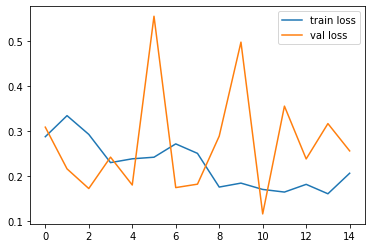

<Figure size 432x288 with 0 Axes>

In [13]:
# loss
plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='val loss')
plt.legend()
plt.show()
plt.savefig('LossVal_loss')


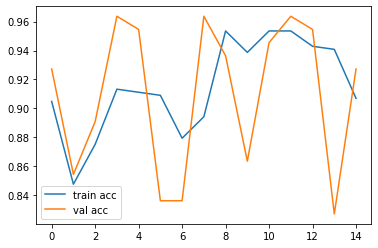

<Figure size 432x288 with 0 Axes>

In [16]:
# accuracies
plt.plot(r.history['accuracy'], label='train acc')
plt.plot(r.history['val_accuracy'], label='val acc')
plt.legend()
plt.show()
plt.savefig('AccVal_acc')


In [0]:
import tensorflow as tf

from keras.models import load_model

model.save('model_vgg19.h5')